In [3]:
import torch
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  # NVIDIA GeForce RTX 4060

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
# Transformaciones: redimensionar, normalizar, convertir a tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ajusta tamaño al que usarás en la red
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(
    root='../002_cancer/train', transform=transform)
test_data = datasets.ImageFolder(
    root='../002_cancer/test', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print("Clases:", train_data.classes)

Clases: ['Benign', 'Malignant']


In [5]:
import os, math, numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# rutas (según tu estructura)
# lo que tenías (mal): BASE_DIR = os.path.join("002cancer")
BASE_DIR = os.path.join("..", "002_cancer")  # desde /notebooks sube a ../002_cancer
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

# parámetros que me pediste
CLASSES = 2
BATCH   = 32
ROWS = COLS = 224
INPUT_CH = 3
EPOCHS  = 15
TEST_MAX_SAMPLES = 2000
SEED    = 42

# dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:",DEVICE)
torch.manual_seed(SEED)
np.random.seed(SEED)

Usando dispositivo: cuda


Epoch 1/15 | Train Loss: 0.4577 | Val Loss: 0.5411 | Val Acc: 0.7470
Epoch 2/15 | Train Loss: 0.4077 | Val Loss: 0.4209 | Val Acc: 0.8010
Epoch 3/15 | Train Loss: 0.3624 | Val Loss: 0.3587 | Val Acc: 0.8395
Epoch 4/15 | Train Loss: 0.3429 | Val Loss: 0.3381 | Val Acc: 0.8570
Epoch 5/15 | Train Loss: 0.3315 | Val Loss: 0.3433 | Val Acc: 0.8480
Epoch 6/15 | Train Loss: 0.3181 | Val Loss: 0.3250 | Val Acc: 0.8620
Epoch 7/15 | Train Loss: 0.3166 | Val Loss: 0.3161 | Val Acc: 0.8580
Epoch 8/15 | Train Loss: 0.3100 | Val Loss: 0.3089 | Val Acc: 0.8710
Epoch 9/15 | Train Loss: 0.3069 | Val Loss: 0.3131 | Val Acc: 0.8620
Epoch 10/15 | Train Loss: 0.3011 | Val Loss: 0.3431 | Val Acc: 0.8535
Epoch 11/15 | Train Loss: 0.2949 | Val Loss: 0.3224 | Val Acc: 0.8555
Epoch 12/15 | Train Loss: 0.2902 | Val Loss: 0.2902 | Val Acc: 0.8850
Epoch 13/15 | Train Loss: 0.2852 | Val Loss: 0.2736 | Val Acc: 0.9000
Epoch 14/15 | Train Loss: 0.2809 | Val Loss: 0.3050 | Val Acc: 0.8710
Epoch 15/15 | Train Loss: 0.2

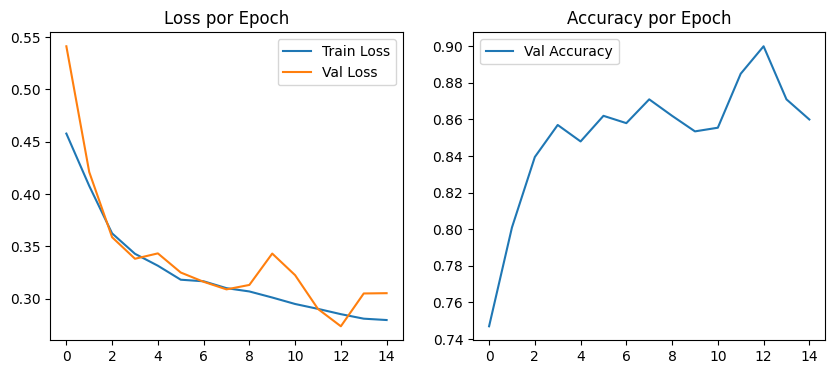

In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

learning_rate = 0.001

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

class CompactCNN(nn.Module):
    """
    CNN pequeña con bloques Conv-BN-ReLU, pooling progresivo y
    AdaptiveAvgPool2d(1) para ser robusta al tamaño de entrada.
    Salida: logits de tamaño (N, CLASSES).
    """
    def __init__(self, in_ch=INPUT_CH, num_classes=CLASSES):
        super().__init__()
        # Etapa 1: 3->32
        self.stage1 = nn.Sequential(
            ConvBNReLU(in_ch, 32),
            ConvBNReLU(32, 32),
            nn.MaxPool2d(2),          # /2
            nn.Dropout(0.10),
        )
        # Etapa 2: 32->64
        self.stage2 = nn.Sequential(
            ConvBNReLU(32, 64),
            ConvBNReLU(64, 64),
            nn.MaxPool2d(2),          # /4 acumulado
            nn.Dropout(0.15),
        )
        # Etapa 3: 64->128
        self.stage3 = nn.Sequential(
            ConvBNReLU(64, 128),
            ConvBNReLU(128, 128),
            nn.MaxPool2d(2),          # /8 acumulado
            nn.Dropout(0.20),
        )
        # Etapa 4: 128->128 (un poco más de capacidad)
        self.stage4 = nn.Sequential(
            ConvBNReLU(128, 128),
            nn.MaxPool2d(2),          # /16 acumulado
            nn.Dropout(0.25),
        )

        # Pooling a 1x1 -> vector de 128 dim sin importar HxW de entrada
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Clasificador
        self.classifier = nn.Sequential(
            nn.Flatten(),             # -> (N, 128)
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.40),
            nn.Linear(128, num_classes)  # logits
        )

        self._init_weights()


    def _init_weights(self):
        # Kaiming/He init para conv y fan_out para lineales
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x  # (N, CLASSES)

# --- Modelo, pérdida y optimizador ---
model = CompactCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Entrenamiento ---
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    val_loss /= len(test_loader.dataset)
    val_acc = correct / len(test_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

# --- Guardar métricas ---
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'model_state': model.state_dict()
}, 'training_metrics_gpu.pth')  # cambiado a gpu

# --- Graficar ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Loss por Epoch')

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend(); plt.title('Accuracy por Epoch')
plt.show()

In [20]:
model.eval()  # modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1)  # la clase con mayor probabilidad
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

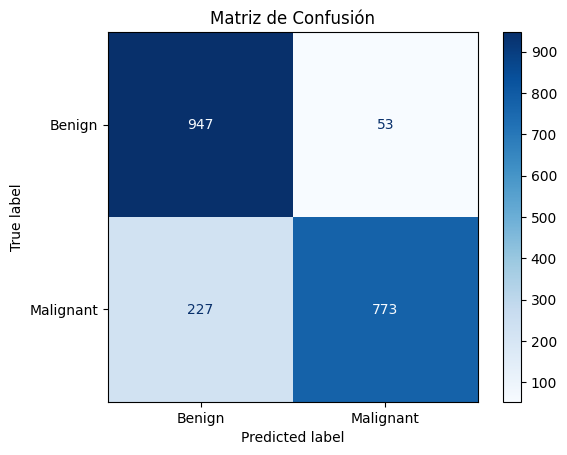

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

In [8]:
import cv2
import matplotlib.pyplot as plt

# --- Configuración GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

num_epochs = 15
learning_rate = 0.001

# --- Transformación con heatmap ---
def add_heatmap_channel(img):
    """
    img: tensor 3x224x224 (RGB)
    devuelve: tensor 4x224x224 (RGB + heatmap)
    """
    img_np = img.permute(1, 2, 0).numpy()  # HxWxC
    gray = cv2.cvtColor((img_np*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    heatmap = cv2.GaussianBlur(gray, (15, 15), 0)  # suaviza
    heatmap = heatmap / 255.0  # normaliza
    heatmap_tensor = torch.tensor(heatmap).unsqueeze(0)  # 1xHxW
    return torch.cat([img, heatmap_tensor], dim=0)  # 4xHxW

# --- CNN ligera que acepta 4 canales ---
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.stage1 = nn.Sequential(
            nn.Conv2d(4, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)   # 224->112
        )
        self.stage2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)  # 112->56
        )
        self.stage3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2) # 56->28
        )
        self.stage4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()                  # 28->28
        )

        # 👇 solo un global pooling al final
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, len(train_data.classes))
        )

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.gap(x)               # -> (N,128,1,1)
        x = torch.flatten(x, 1)       # -> (N,128)
        return self.classifier(x)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Entrenamiento con heatmap ---
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # agregar canal de heatmap
        images = torch.stack([add_heatmap_channel(img) for img in images])
        images, labels = images.to(device).float(), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = torch.stack([add_heatmap_channel(img) for img in images])
            images = images.float()  # ✅ importante
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    
    val_loss /= len(test_loader.dataset)
    val_acc = correct / len(test_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

# --- Guardar métricas ---
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'model_state': model.state_dict()
}, 'training_metrics_gpu_heatmap.pth')

# --- Graficar ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Loss por Epoch')
plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend(); plt.title('Accuracy por Epoch')
plt.show()

Usando dispositivo: cuda


KeyboardInterrupt: 